# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

В план работ с данными войдет:
- изучение общей информации
- обработка данных
- визуализация данных
- обработка контрольных моментов, связанных с выводом
- общий вывод.

__Задачей является выявление параметров рыночной стоимости объектов недвижимости.__

# 1  Откройте файл с данными и изучите общую информацию. 

# 1.1 Открываем и изучаем данные

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
9361,20,5900000.0,112.00,2015-03-29T00:00:00,4,NaN,5.0,76.40,4,False,False,False,9.5,3.0,Красное Село,26645.0,30070.0,0.0,NaN,0.0,NaN,714.0
7183,9,3180000.0,30.00,2018-09-06T00:00:00,1,2.7,9.0,14.00,5,NaN,False,False,7.8,NaN,посёлок Шушары,23451.0,29237.0,0.0,NaN,1.0,683.0,96.0
10162,11,8000000.0,56.79,2017-10-01T00:00:00,2,NaN,5.0,32.08,5,NaN,False,False,NaN,0.0,Пушкин,14517.0,26670.0,1.0,517.0,0.0,NaN,4.0
18120,9,4850000.0,36.00,2018-02-24T00:00:00,2,2.7,27.0,25.00,11,False,False,False,5.0,2.0,Санкт-Петербург,33736.0,14835.0,0.0,NaN,0.0,NaN,130.0
9924,16,4200000.0,40.00,2018-09-10T00:00:00,1,NaN,25.0,20.00,6,NaN,False,False,10.5,NaN,Санкт-Петербург,24078.0,11729.0,1.0,529.0,0.0,NaN,49.0


In [3]:
df.shape

(23699, 22)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

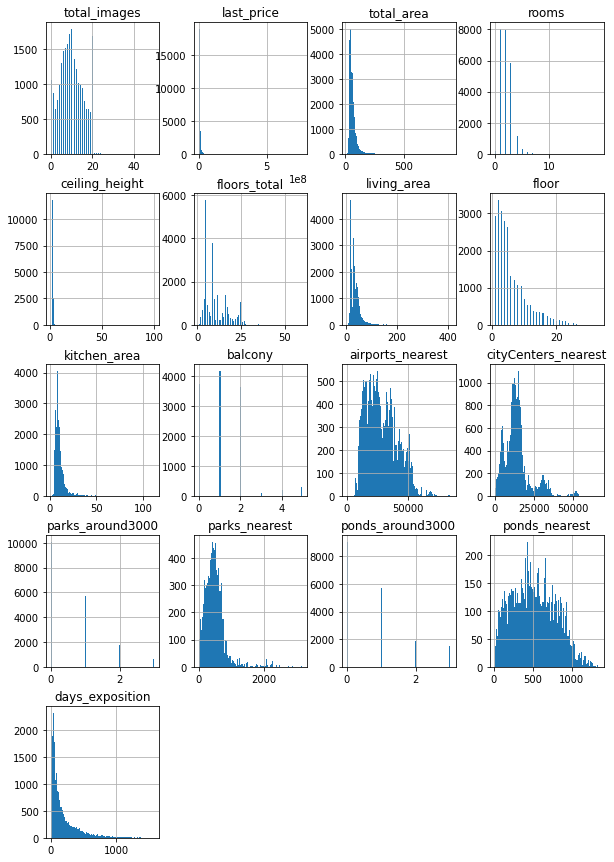

In [5]:
df.hist(figsize=(10, 15), bins=100);

# 1.2. Первичные выводы

---В общем и целом данные состоят из 23699 строк и 22 колонок. Большинство пробелов в категории "апартаменты", "парков поблизости" и "озер поблизости".
Аномальные выбросы есть, но в целом с ними можно побороться---

# 2 Предобработка данных

# 2.1 Изучение и удаление пропущенных значений

--- изучим и проверим пропущенные значения. перед заполнением нулями, постараемся количественные колонки заполнить средним или медианным значением---


In [6]:
df.isna().sum().sort_values(ascending=False)

is_apartment            20924
parks_nearest           15620
ponds_nearest           14589
balcony                 11519
ceiling_height           9195
airports_nearest         5542
cityCenters_nearest      5519
ponds_around3000         5518
parks_around3000         5518
days_exposition          3181
kitchen_area             2278
living_area              1903
floors_total               86
locality_name              49
total_images                0
last_price                  0
studio                      0
floor                       0
rooms                       0
first_day_exposition        0
total_area                  0
open_plan                   0
dtype: int64

In [7]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

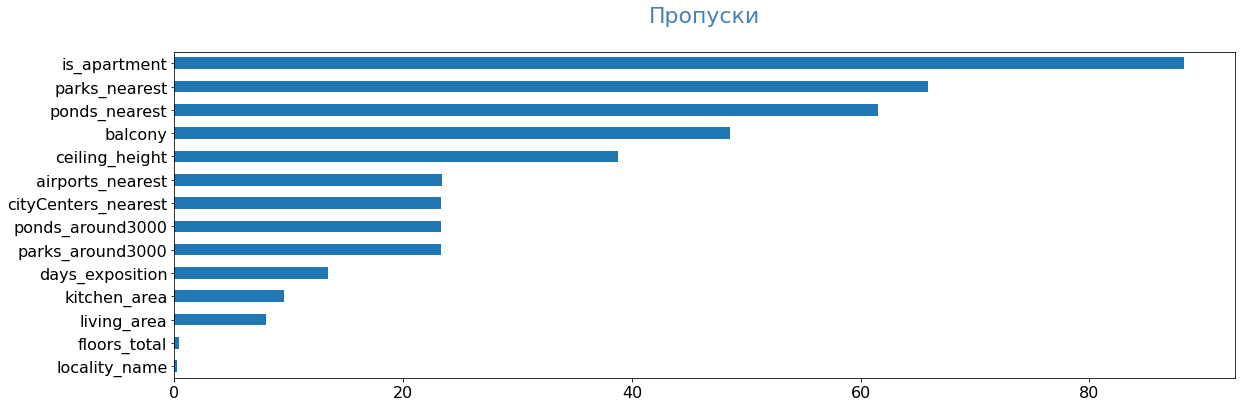

In [8]:
pass_value_barh(df)

---проверим уместность и возможность замены данных, 
проведем анализ и возможную замену данных ----

In [9]:
#чат и советы преподавателя дают понять, что в анализе должна присутствовать и творческая сторона вопроса
#(немного не понятно, что мы можем убрать, что нет)
#попробую переписать часть предобработки(вообще бы я начал сначала), основываясь на опыте ребят, которые общаются в телеге 
#и советов знакомых сайентистов

In [10]:
#самые многочисленные пропуски это категория аппартов, 
df['is_apartment'] = df['is_apartment'].astype('bool')
df.sample(5)
#изменил категорию аппартов на булевую, теперь ни пропусков, ни нулей

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7218,1,4280000.0,66.00,2017-12-01T00:00:00,2,NaN,25.0,35.00,9,True,False,False,12.00,NaN,посёлок Шушары,13908.0,19694.0,0.0,NaN,1.0,645.0,211.0
18109,7,10700000.0,135.48,2018-09-28T00:00:00,4,NaN,18.0,76.65,3,True,False,False,19.50,NaN,Санкт-Петербург,32158.0,8297.0,0.0,NaN,1.0,564.0,20.0
18886,11,2640000.0,37.29,2017-04-08T00:00:00,1,NaN,27.0,15.53,23,False,False,False,9.26,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,89.0
23264,5,4450000.0,63.00,2016-11-01T00:00:00,3,2.5,9.0,40.00,8,True,False,False,7.20,2.0,Петергоф,45930.0,49354.0,1.0,510.0,0.0,NaN,616.0
10938,11,5300000.0,44.70,2019-04-02T00:00:00,2,2.7,9.0,27.40,6,True,False,False,6.00,NaN,Санкт-Петербург,17790.0,16177.0,1.0,586.0,0.0,NaN,NaN


In [11]:
df['parks_nearest'].isna().sum()
df['parks_around3000'].isna().sum()#кажется, что эти данные между удаленностью и наличием парков коррелируют, 
#возможно, что заполняли одного из них
#или в программе были разные методы заполнения в разных версиях
parks_over_3000 = df.query('parks_nearest > 3000')['parks_nearest'].mean()
df['parks_nearest']=df['parks_nearest'].fillna(parks_over_3000)
df['parks_nearest'].isna().sum()

0

In [12]:
df['ponds_nearest'].isna().sum()
df['ponds_around3000'].isna().sum()#предположу аналогичную механику с парками
ponds_over_3000 = df.query('ponds_nearest > 3000')['ponds_nearest'].mean()
df['ponds_nearest']=df['ponds_nearest'].fillna(parks_over_3000)
df['ponds_nearest'].isna().sum()
#ponds_nearest

0

In [13]:
#важной метрикой (по мнению многих), является высота потолков.
df.query('ceiling_height == 0')#совсем нулевых значений нет, есть наны и некорректно заполненые данные
df['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [14]:
df.query('ceiling_height > 2 | ceiling_height < 7').ceiling_height.mean()#попробуем не трогать условно исторические
#квартиры с возможно высокими потолками, а остальные - аномальные - заменим на среднее - 2.77
df['ceiling_height'] = np.where((df.ceiling_height < 2), 2.77, df.ceiling_height)
df['ceiling_height'] = np.where((df.ceiling_height > 7), 2.77, df.ceiling_height)
df.query('ceiling_height < 2 and ceiling_height > 7')['ceiling_height'].sum()#аномальных потолков не осталось
df['ceiling_height'] = df['ceiling_height'].fillna(2.77)
df['ceiling_height'].unique()
df['ceiling_height'].describe()
#пострались оставить исторические потолки на месте

count    23699.000000
mean         2.743616
std          0.218807
min          2.000000
25%          2.600000
50%          2.770000
75%          2.770000
max          6.000000
Name: ceiling_height, dtype: float64

In [15]:
df['floors_total'].isna().sum()
df['floors_total'].describe()#нулевых значений 86, но есть и минимальные в 1 этаж, посмотрим что это за этажи
df.query('floors_total == 5')#в одноэтажных домах квартиры везде на первом этаже, также и дальше 
def floors_lie(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor <= floors_total:
        return '1'
    elif floor > floors_total:
        return '0'
df['floors_lie'] = df.apply(floors_lie, axis = 1)
df.query('floors_lie == 0')#проверка показала, что этажность дома не выше значения этажа
df.loc[df['floors_total'].isna()]#после проверки, осталось те же 86 домов со значением Нан

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_lie
186,12,11640000.0,65.2,2018-10-02T00:00:00,2,2.77,NaN,30.80,4,True,False,False,12.00,NaN,Санкт-Петербург,39197.0,12373.0,1.0,123.00,0.0,3114.25,49.0,None
237,4,2438033.0,28.1,2016-11-23T00:00:00,1,2.77,NaN,20.75,1,True,False,False,NaN,0.0,Санкт-Петербург,22041.0,17369.0,0.0,3114.25,1.0,374.00,251.0,None
457,4,9788348.0,70.8,2015-08-01T00:00:00,2,2.77,NaN,38.40,12,True,False,False,10.63,0.0,Санкт-Петербург,37364.0,8322.0,2.0,309.00,2.0,706.00,727.0,None
671,4,6051191.0,93.6,2017-04-06T00:00:00,3,2.77,NaN,47.10,8,True,False,False,16.80,0.0,Санкт-Петербург,22041.0,17369.0,0.0,3114.25,1.0,374.00,123.0,None
1757,5,3600000.0,39.0,2017-04-22T00:00:00,1,2.77,NaN,NaN,9,True,False,False,NaN,0.0,Санкт-Петербург,22735.0,11618.0,1.0,835.00,1.0,652.00,77.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22542,5,8500000.0,63.5,2017-05-24T00:00:00,2,2.80,NaN,NaN,3,True,False,False,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,3114.25,1.0,853.00,512.0,None
22656,4,4574160.0,64.5,2017-04-02T00:00:00,2,2.77,NaN,31.70,20,True,False,False,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,3114.25,1.0,374.00,127.0,None
22808,0,14569263.0,110.4,2016-11-20T00:00:00,3,2.77,NaN,45.38,6,True,False,False,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,3114.25,0.0,3114.25,260.0,None
23590,0,21187872.0,123.3,2017-04-25T00:00:00,3,2.77,NaN,50.40,18,True,False,False,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,3114.25,0.0,3114.25,104.0,None


In [16]:
df.loc[df['balcony'].isna()]#11500 значений пропущено по балконам, в целом это может соответстовать отсутствию оного.
df['balcony']=df['balcony'].fillna(0).astype('int')
df['balcony'].isna().sum()#заменили наны на нули, теперь отсутствие балкона подтверждено документально 

0

In [17]:
# колонки airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000 имеют одинаковые пропуски или кол-во близкое к одинаковому
df['airports_nearest'].describe()
df['airports_nearest'].isna().sum()#5500 пропусков
df.query('airports_nearest == 0')#но всего одно значение с нулем
df.loc[df['airports_nearest'] == 0, 'airports_nearest'] = None#уберем его из статистики
df['airports_nearest'].min()#ближайшая квартира в 6.5км
df['airports_nearest'].isna().sum()
df['airports_nearest'] = df['airports_nearest']/1000#переведу в км для удобства
df['airports_nearest'].min()#ближайшая квартира к аэропорту в км

6.45

In [18]:
df['cityCenters_nearest'].describe()
df['cityCenters_nearest'] = df['cityCenters_nearest']/1000#выведу в виде км, для удобства
df['cityCenters_nearest'].isna().sum()#5500 значений пропущенных, но чем их заполнять? нулями некорректно. возможно
#эти квартиры находятся довольно далеко или они не были привязаны к картографическим меткам
df.query('cityCenters_nearest == 0')
df['cityCenters_nearest'].describe()

count    18180.000000
mean        14.191278
std          8.608386
min          0.181000
25%          9.238000
50%         13.098500
75%         16.293000
max         65.968000
Name: cityCenters_nearest, dtype: float64

In [19]:
df['days_exposition'].describe()# среднее - 180, медиана - 95 дней, минимальное значение -1 и максимальное - 1580
df['days_exposition'].isna().sum()#скорее всего - пропуски это еще продающиеся квартиры

3181

In [20]:

df.query('living_area < 8')#неправдоподобных жилых площадей немного - 8 строк, но если их изменять(допустим, умножать на 10)
#то тогда они станут больше общей площади
df.loc[df['living_area'] < 4, 'living_area'] = df['living_area']*10
df.query('living_area < 4')#но у жилой площади меньше 4 согласуется ошибка в десятичной доле, поэтому уберу их таким способом

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_lie


In [21]:
df['kitchen_area'].describe()#среднее по кухням - 10 и медиана -9, довольно близко
df['kitchen_area'].isna().sum()#2278 строк с пропусками, там, где площадь кухни компенсируется остатльной площадью
df['kitchen_area'] = df['kitchen_area'].fillna(0)
df.query('kitchen_area < 8')#8850 строк с кухнями меньше 8кв.м., минимальный размер кухни согласно снип - 8кв.
df.query('kitchen_area < 5')#кухни около 5 кв.м находятся в квартирах с не большой общей площадью 
#уберем совсем мальнкие кухни как неправдоподбные и оставим большие по верхнему квантилю
df['kitchen_area'].quantile([0.01, .5, .90, .9976])#постараемся усреднить 
kitchen_area_mean = df.query('kitchen_area > 5' and 'kitchen_area < 15')['kitchen_area'].mean()
df.loc[df['kitchen_area'] < 5, 'kitchen_area'] = kitchen_area_mean
df['kitchen_area'].describe()

count    23699.000000
mean        10.336412
std          5.653154
min          5.000000
25%          7.500000
50%          9.000000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64

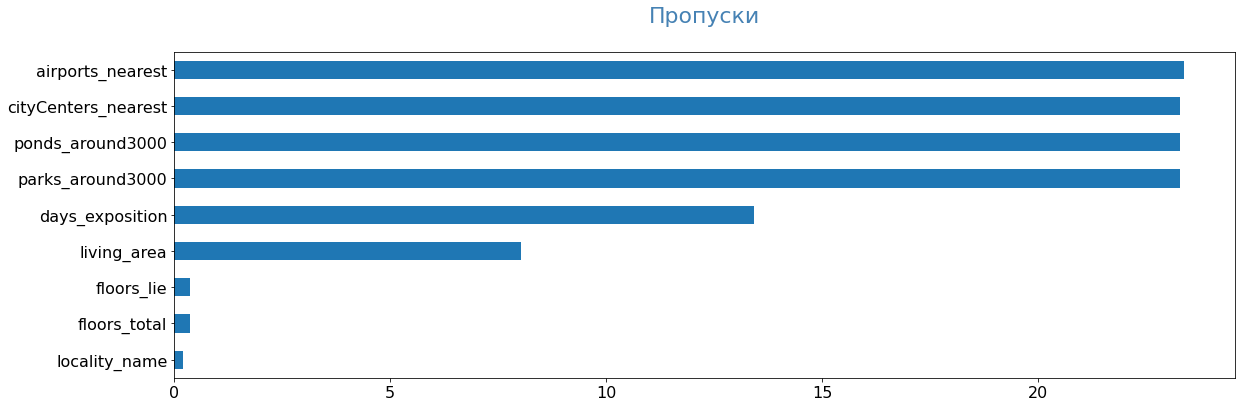

In [22]:
pass_value_barh(df)

---пропуски остались в колонках, где пока что не стоит их удалять

удаленность от объектов говорит о общей тенденции в этих ошибках - их довольно одиноковое количество

дни продаж говорят о незакрытых сделках

а жилая площадь - о том, что это окрытое пространство и нет возможности выделить жилую площадь

--- Пропуски присутсвтуют во многих группах, но самые многочисленные это:---
 - категория "квартира" - пропуски почти по всему массиву, а где не пропущен, то по смежным категориям "студия" или "открытый план" также стоят False.  Возможно, что этим категориям вообще не уделяют внимания, как не важным.
 - категории "парк или пруд рядом" также отмечены в большинстве, как пропуски.Это категориальные величины. Может нет рядом ни парка, ни озера
 - категория "балкон" - ну нет балкона. Ставим 0.
 - категория "высота потолков". аномально низкие и выше 6 метров заменим на среднее
 - категории "аэропорт или центр поблизости" со значением Nan принадлежат удаленным населенным пунктам и их 0 не будет мешать исследованию
 - категории "парк, озеро в округе" содержат небольшие числа, их количество, т.е. отсуствие значения воспримем как отсутствие парка или озера

 
 дубликатов нет

# 2.2. Типы данных в столбцах

--- заменим числа с плавающей точкой на целочисленные и упорядочим булевые значения ---

In [23]:
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                   int64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
floors_lie               object
dtype: object

In [24]:
df['floors_total'] = df['floors_total'].fillna(0)
df['floors_total'] = df['floors_total'].astype('int')
df['parks_around3000'] = df['parks_around3000'].fillna(0)
df['parks_around3000'] = df['parks_around3000'].astype('int')
df['ponds_around3000'] = df['ponds_around3000'].fillna(0)
df['ponds_around3000'] = df['ponds_around3000'].astype('int')
#данные по балконам заменили при предобработке

# 2.3 замена значений
--- Перевели  значения  - этажи, балконы, количество парков и прудов поблизости в целочисленный вариант и категорию аппартамент - в булевую.
Первая задача нужна, чтобы не сбить расчеты с числами с плавующей точкой, а второй - чтобы было удобнее работать с двумя другими подобными категориями - "студия" и "открытое пространство" ---

In [25]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

--- наведем порядок в названиях населенных пунктов ---

In [26]:
df['locality_name'] = df['locality_name'].str.replace('поселок', 'посёлок')
df['locality_name'] = df['locality_name'].str.replace('поселок городского типа', 'посёлок городского типа')
df['locality_name'] = df['locality_name'].str.replace('городской поселок', 'городской посёлок')
df['locality_name'] = df['locality_name'].str.replace('Санкт-Петербург', 'Санкт_Петербург')

In [27]:
df['locality_name'].value_counts()

Санкт_Петербург                                      15721
посёлок Мурино                                         556
посёлок Шушары                                         440
Всеволожск                                             398
Пушкин                                                 369
                                                     ...  
деревня Кисельня                                         1
деревня Мануйлово                                        1
посёлок Жилпосёлок                                       1
деревня Меньково                                         1
посёлок при железнодорожной станции Приветнинское        1
Name: locality_name, Length: 330, dtype: int64

--- данные о потолках имеют ошибки, возможно связанные, скорее всего, с неправильным заполнением. Так, например, есть значения 27. Вполне возможно, что это высота 2.7, но записанная с ошибкой ---

---  заполнили и изменили пустующие значения ---

### check ano

In [28]:
# check
data = df.copy()

In [29]:
# check
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  int64  
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [30]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  int64  
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  int64  
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [31]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир
# сырые данные

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,699.00","23,699.00","23,699.00","20,518.00","23,699.00","21,796.00","23,699.00","23,699.00","23,699.00"
min,0.00,12.00,2.00,1.00,"12,190.00",5.00,5.00,1.00,0.00
max,19.00,900.00,6.00,"1,580.00","763,000,000.00",409.70,112.00,33.00,60.00


In [32]:
# check
data.rooms.value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12
9,8


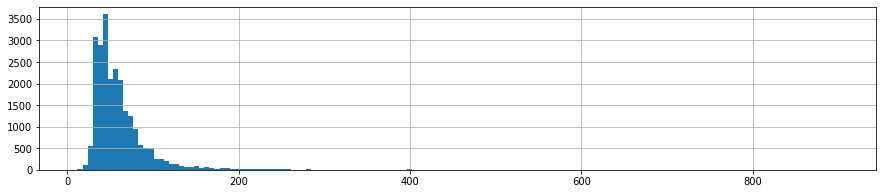

In [33]:
# check
data.total_area.hist(bins = 150, figsize = (15,3));

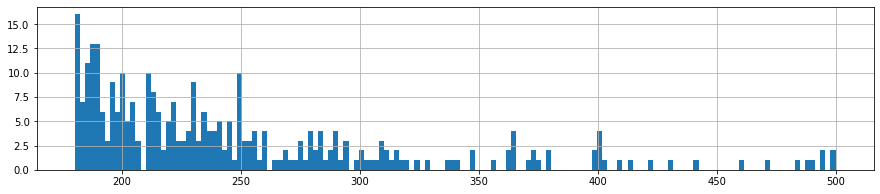

In [34]:
# check
data.total_area.hist(bins = 150, figsize = (15,3), range = (180,500));

In [35]:
# check

# Значения параметров объектов недвижимости на разных квантилях

(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  
        'kitchen_area', 'floor',   'floors_total']]
    .quantile([0.01, .5, .90, .9976])  
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
0.01,1.00,25.20,2.50,4.00,"1,000,000.00",13.00,5.00,1.00,2.00
0.5,2.00,52.00,2.77,95.00,"4,650,000.00",30.00,9.00,4.00,9.00
0.9,3.00,93.52,3.00,460.00,"10,914,231.20",55.00,15.10,13.00,22.00
0.9976,7.00,309.74,4.00,"1,311.28","82,000,000.00",181.25,50.00,25.00,27.00



остались аномалии и редкости в колонках:
    'rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floors_total'
стоит учесть наличие пропусков при фильтрации данных

In [36]:
df = df.loc[df['rooms'] < 9]
#df = df.loc[df['rooms'] != 0]
#удаляем квартиры с количеством комнат больше 9 и равные 0, их потеря не сильно скажется на анализе, но очистит среднее
df['rooms'].value_counts().to_frame()

,rooms
1,8047
2,7940
3,5814
4,1180
5,326
0,197
6,105
7,59
8,12


In [37]:
data['total_area_cut'] = pd.cut(data['total_area'], 25)#разобъем колонку на 25 частей, в расчете выделить 1/1000 из данных
data['total_area_cut'].value_counts().to_frame()#считаю, что объем данных падает после квадратуры в 180, но сделаю с запасом - отсеку лишнее после 250

,total_area_cut
"(11.112, 47.52]",10256
"(47.52, 83.04]",10072
"(83.04, 118.56]",2255
"(118.56, 154.08]",596
"(154.08, 189.6]",255
"(189.6, 225.12]",101
"(225.12, 260.64]",69
"(260.64, 296.16]",31
"(296.16, 331.68]",18
"(367.2, 402.72]",13


In [38]:
df = df.loc[df['total_area'] < 300]
df['total_area'].value_counts().to_frame()

,total_area
45.00,419
42.00,383
60.00,347
31.00,346
44.00,345
...,...
180.80,1
173.60,1
30.11,1
127.20,1


In [39]:
df['ceiling_height'].unique()
#не буду выводить все, логика такая же как и выше - проверка, сортировка, анализ, обрезка, проверка
df['ceiling_height_cut'] = pd.cut(df['ceiling_height'], 25)
df['ceiling_height_cut'].value_counts().sort_index().to_frame()#потолки выше 4.64 резко падают в количестве, отсекаем то, что выше
#присутсвуют значения в 2.2 и выше, их оставлю
df = df.loc[df['ceiling_height'] < 4.7]
df['ceiling_height'].value_counts().to_frame()

,ceiling_height
2.77,9265
2.50,3514
2.60,1646
2.70,1573
3.00,1105
...,...
2.49,1
3.76,1
3.88,1
2.34,1


In [40]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23615 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   total_images          23615 non-null  int64   
 1   last_price            23615 non-null  float64 
 2   total_area            23615 non-null  float64 
 3   first_day_exposition  23615 non-null  object  
 4   rooms                 23615 non-null  int64   
 5   ceiling_height        23615 non-null  float64 
 6   floors_total          23615 non-null  int64   
 7   living_area           21728 non-null  float64 
 8   floor                 23615 non-null  int64   
 9   is_apartment          23615 non-null  bool    
 10  studio                23615 non-null  bool    
 11  open_plan             23615 non-null  bool    
 12  kitchen_area          23615 non-null  float64 
 13  balcony               23615 non-null  int64   
 14  locality_name         23566 non-null  object  
 15  ai

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23615 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   total_images          23615 non-null  int64   
 1   last_price            23615 non-null  float64 
 2   total_area            23615 non-null  float64 
 3   first_day_exposition  23615 non-null  object  
 4   rooms                 23615 non-null  int64   
 5   ceiling_height        23615 non-null  float64 
 6   floors_total          23615 non-null  int64   
 7   living_area           21728 non-null  float64 
 8   floor                 23615 non-null  int64   
 9   is_apartment          23615 non-null  bool    
 10  studio                23615 non-null  bool    
 11  open_plan             23615 non-null  bool    
 12  kitchen_area          23615 non-null  float64 
 13  balcony               23615 non-null  int64   
 14  locality_name         23566 non-null  object  
 15  ai

In [42]:
df['days_exposition'].unique()
df['days_exposition_cut'] = pd.cut(df['days_exposition'], 25)
df['days_exposition_cut'].value_counts().sort_index().to_frame()
#около полвины продаж в первом отрезке, до 63 дней.самое большое это 1500 дней. 
#с отрезка в 1300 дней отсеку данные, как аномальные
df = df[df.days_exposition.lt(1300) & df.days_exposition.gt(5) | df.days_exposition.isna()]
df['days_exposition'].value_counts().to_frame()

,days_exposition
45.0,880
60.0,538
7.0,234
30.0,207
90.0,202
...,...
1070.0,1
1278.0,1
742.0,1
762.0,1


In [43]:
# check
df.shape[0]

23075

In [44]:
df['last_price'].unique()
df['last_price_cut'] = pd.cut(df['last_price'], 20)
df['last_price_cut'].value_counts().sort_index().to_frame()
#после 16млн. есть 4 продажи и максимум составляет 40 млн.
#хотя и после 40 млн. только 9 продаж+совсем аномальные до 40млн.
df = df[df.last_price.lt(40000000)&df.last_price.gt(15000)|df.last_price.isna()]
df['last_price'].value_counts().sort_index().to_frame()

,last_price
430000.0,2
440000.0,1
450000.0,4
470000.0,3
480000.0,1
...,...
39000000.0,4
39744000.0,1
39773280.0,1
39900000.0,6


In [45]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22929 entries, 0 to 23698
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   total_images          22929 non-null  int64   
 1   last_price            22929 non-null  float64 
 2   total_area            22929 non-null  float64 
 3   first_day_exposition  22929 non-null  object  
 4   rooms                 22929 non-null  int64   
 5   ceiling_height        22929 non-null  float64 
 6   floors_total          22929 non-null  int64   
 7   living_area           21081 non-null  float64 
 8   floor                 22929 non-null  int64   
 9   is_apartment          22929 non-null  bool    
 10  studio                22929 non-null  bool    
 11  open_plan             22929 non-null  bool    
 12  kitchen_area          22929 non-null  float64 
 13  balcony               22929 non-null  int64   
 14  locality_name         22882 non-null  object  
 15  ai

In [46]:
df['living_area'].unique()
df['living_area_cut'] = pd.cut(df['living_area'], 20)
df['living_area_cut'].value_counts().sort_index().to_frame()
#основная масса это квартиры не больше 63кв.м.
#квартир больше 205 кв. очень мало. есть всплеск на данных в 250кв., но их можно не учитывать, как нетипичные, я думаю
df = df[df.living_area.lt(140)&df.living_area.gt(8)|df.living_area.isna()]
df['living_area'].value_counts().sort_index().to_frame()

,living_area
8.3,1
8.4,1
8.5,1
8.9,1
9.0,9
...,...
136.0,1
136.1,1
137.7,1
139.4,1


In [47]:
# check
df.shape[0]

22857

In [48]:
df['kitchen_area'].unique()
df['kitchen_area_cut'] = pd.cut(df['kitchen_area'], 30)
df['kitchen_area_cut'].value_counts().sort_index().to_frame()
#кухонь д 4.8 метров - 92, оставлю нижний порог в 4, а верхний в 50, после 50 резкий спад количества
#есть всплески на 60-65, но уберу их, как нетипичные
df = df.loc[df['kitchen_area'] >= 4]
df = df.loc[df['kitchen_area'] < 50]
df['kitchen_area'].value_counts().to_frame()

,kitchen_area
7.959033,2303
6.000000,1268
10.000000,1228
8.000000,1087
9.000000,1083
...,...
15.720000,1
13.730000,1
14.740000,1
13.410000,1


In [49]:
df['floors_total'].unique()
df['floors_total_cut'] = pd.cut(df['floors_total'], 20)
df['floors_total_cut'].value_counts().sort_index().to_frame()
#после 27 этажа люди поднимаются редко, но упорные покупают квартиры и на 36. дальше только уникальные личности
#сделаю срез по 36 этаж
df = df.loc[df['floors_total'] < 36]
df['floors_total'].value_counts().to_frame()

,floors_total
5,5584
9,3644
16,1335
12,1321
10,1141
4,1138
25,1047
6,838
17,817
3,639


In [50]:
df['floors_total'].describe()

count    22829.000000
mean        10.667528
std          6.609501
min          0.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         35.000000
Name: floors_total, dtype: float64

In [51]:
df['floor'].describe()

count    22829.000000
mean         5.899076
std          4.897027
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

In [52]:
df.drop(['ceiling_height_cut', 'last_price_cut', 'living_area_cut', 'kitchen_area_cut', 'floors_total_cut', 'days_exposition_cut'], axis=1, inplace=True)

In [53]:
# check

# Показатели о кол-ве объявлений в датасете, минимальных и максимальных значениях 
# в выбранных параметрах о продаже квартир

(
    df[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area',
          'floor', 'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"22,829.00","22,829.00","22,829.00","19,724.00","22,829.00","20,981.00","22,829.00","22,829.00","22,829.00"
min,0.00,12.00,2.00,6.00,"430,000.00",8.30,5.00,1.00,0.00
max,8.00,295.00,4.50,"1,299.00","39,990,000.00",139.80,49.40,33.00,35.00


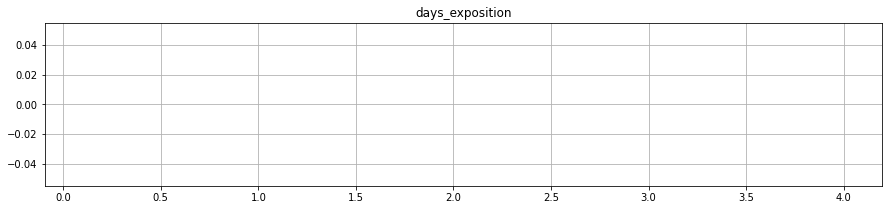

In [54]:
# check
df.hist(column = 'days_exposition', bins = 50, figsize = (15,3), range = (0.1,4));

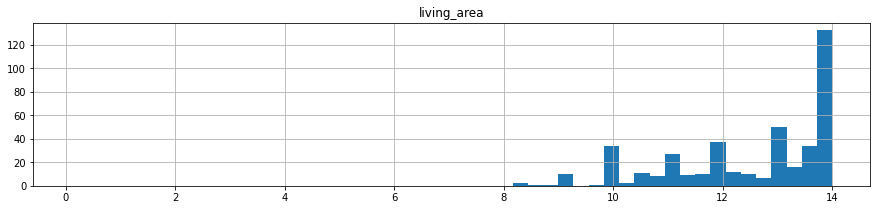

In [55]:
# check
df.hist(column = 'living_area', bins = 50, figsize = (15,3), range = (0.1,14));

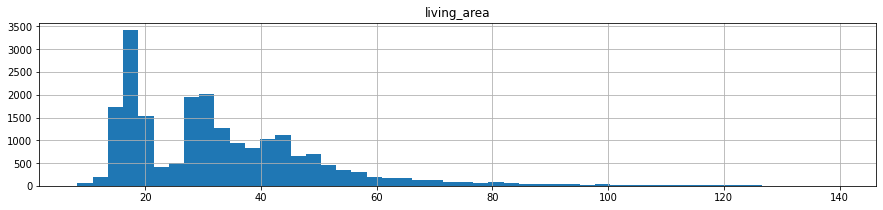

In [56]:
# check
df.hist(column = 'living_area', bins = 50, figsize = (15,3));

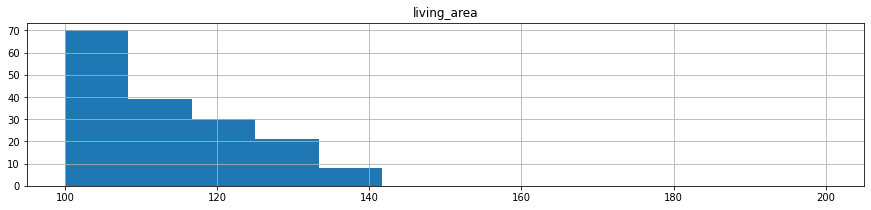

In [57]:
# check
df.hist(column = 'living_area', bins = 12, figsize = (15,3), range = (100, 200));

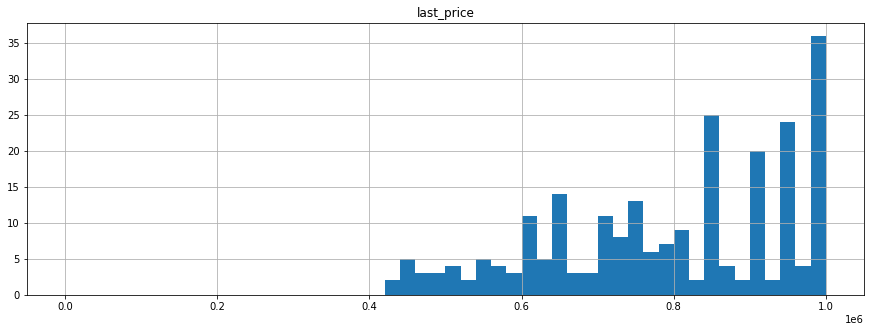

In [58]:
df.hist(column = 'last_price', bins = 50, figsize = (15,5), range = (0, 1000000));

### check add

# 3.1  Посчитаем значения и добавим в таблицу новые столбцы

--- добавляем колонку со средней ценой за кв.метр ---

In [59]:
df['price_square_meter'] = (df['last_price']/df['total_area']).astype(int)

--- средняя цена за метр.кв. по всему датафрейму ---

In [60]:
square_meter_cost_mean = df['price_square_meter'].mean().astype(int)
square_meter_cost_mean

96975

--- изменяем формат дат, отсекаем время, добавляем колонки с днем, месяцем и годом публикации ---

In [61]:
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d') 
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday
df['month_exposition'] = df['first_day_exposition'].dt.month
df['year_exposition'] = df['first_day_exposition'].dt.year

--- разбиваем данные о этажах на категории ---

In [62]:
df['floors_total'].unique()

array([16, 11,  5, 14, 12, 26, 24, 27,  9,  6, 17, 25,  3, 23, 19, 18,  4,
       22,  2, 10,  7, 13, 15,  8,  0, 20, 28, 21, 35, 34,  1, 29, 33])

In [63]:
df.loc[df['floor'] == 1, 'floor_category'] = 'первый'
df.loc[df['floor'] == df['floors_total'], 'floor_category'] = 'последний'
df.loc[df['floor_category'].isna(), 'floor_category'] = 'другой'

--- переводим метры от центра до объекта продажи в километры и проверяем ---

In [64]:
df['cityCenters_nearest'] = df['cityCenters_nearest'].fillna(0)
df['cityCenters_nearest'] = df['cityCenters_nearest'].astype(int)
df['cityCenters_nearest'].head()

0    16
1    18
2    13
4     8
5     0
Name: cityCenters_nearest, dtype: int64

--- промежуточная проверка данных, все на месте ---

In [65]:
df.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,floors_lie,price_square_meter,weekday_exposition,month_exposition,year_exposition,floor_category
16568,11,7300000.0,58.0,2017-08-08,2,2.77,20,32.4,17,True,False,False,11.2,1,Санкт_Петербург,15.654,7,1,725.00,0,3114.25,27.0,1,125862,1,8,2017,другой
7715,10,3900000.0,36.8,2018-11-13,1,2.50,16,19.7,14,True,False,False,6.5,0,Санкт_Петербург,48.762,16,0,3114.25,0,3114.25,7.0,1,105978,1,11,2018,другой
3227,6,2950000.0,54.0,2017-11-27,2,2.77,9,28.0,2,True,False,False,12.0,0,Кингисепп,NaN,0,0,3114.25,0,3114.25,100.0,1,54629,0,11,2017,другой
18746,7,1700000.0,38.0,2018-12-12,2,2.50,2,26.0,1,True,False,False,7.0,0,посёлок Петровское,NaN,0,0,3114.25,0,3114.25,120.0,1,44736,2,12,2018,первый
10272,0,4700000.0,41.0,2017-10-13,1,2.80,8,19.0,3,True,False,False,10.0,0,Санкт_Петербург,38.832,13,0,3114.25,0,3114.25,56.0,1,114634,4,10,2017,другой
20041,14,18990000.0,121.0,2018-03-26,4,3.40,5,56.3,2,True,False,False,28.0,0,Санкт_Петербург,24.442,4,3,647.00,0,3114.25,298.0,1,156942,0,3,2018,другой
13772,9,3200000.0,35.5,2017-10-27,1,2.77,18,16.1,12,True,False,False,8.3,0,деревня Новое Девяткино,NaN,0,0,3114.25,0,3114.25,116.0,1,90140,4,10,2017,другой
3337,11,6500000.0,62.0,2018-10-10,3,2.55,14,41.3,11,True,False,False,7.8,4,Санкт_Петербург,41.512,11,1,554.00,0,3114.25,59.0,1,104838,2,10,2018,другой
1171,15,7800000.0,62.6,2017-04-21,2,2.77,17,39.5,15,True,False,False,10.0,0,Санкт_Петербург,34.519,12,0,3114.25,0,3114.25,20.0,1,124600,4,4,2017,другой
7099,20,8299000.0,94.0,2018-06-25,4,3.00,5,57.0,4,True,False,False,10.0,0,Санкт_Петербург,19.621,3,0,3114.25,1,167.00,121.0,1,88287,0,6,2018,другой


### check eda

# Проведена следующая работа:
**введены новые колонки:**

-цена одного квадратного метра<br>
-день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)<br>
-месяц публикации объявления<br>
-год публикации объявления<br>
-тип этажа квартиры (значения — «первый», «последний», «другой»)<br>
-расстояние до центра города в километрах<br>
    
**заменены и заполнены пропущенные значения**

# 4 Проведем исследовательский анализ данных

In [66]:
df['total_area'].describe()

count    22829.000000
mean        58.038675
std         26.567683
min         12.000000
25%         40.000000
50%         51.900000
75%         68.500000
max        295.000000
Name: total_area, dtype: float64

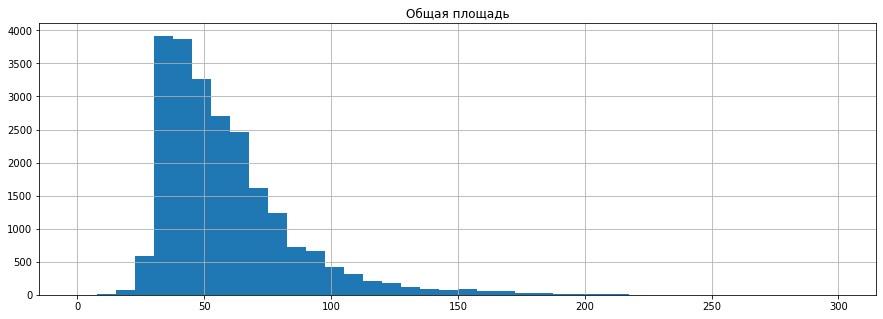

In [67]:
df['total_area'].hist(bins=40, range = (0, 300), figsize= (15, 5));
plt.title('Общая площадь');

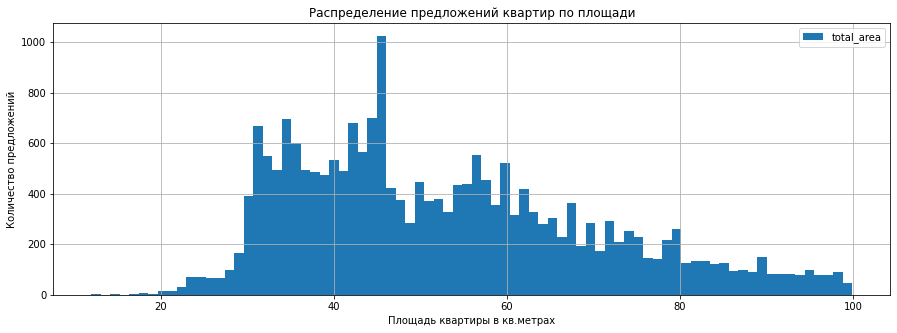

In [68]:
df.query('total_area < 100').sort_values(by='total_area', ascending=True).plot(kind='hist', y='total_area',title='Распределение предложений квартир по площади',bins=80, figsize=(15,5), grid=True)

plt.xlabel('Площадь квартиры в кв.метрах')
plt.ylabel('Количество предложений')
plt.show()

--- средняя площадь квартиры 60 кв.м., минимальная - 12(коммуналка?) ---

In [69]:
df['living_area'].describe()

count    20981.000000
mean        33.161437
std         17.128577
min          8.300000
25%         18.600000
50%         30.000000
75%         42.000000
max        139.800000
Name: living_area, dtype: float64

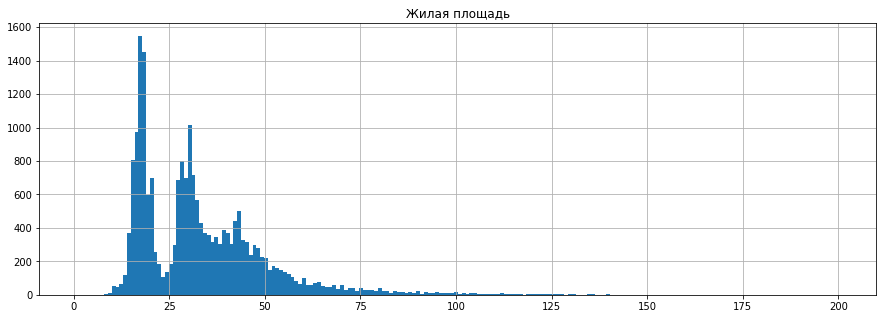

In [70]:
df['living_area'].hist(bins=200, range=(1, 200), figsize= (15, 5));
plt.title('Жилая площадь');

---два пика это зависимость от количества комнат в квартирах

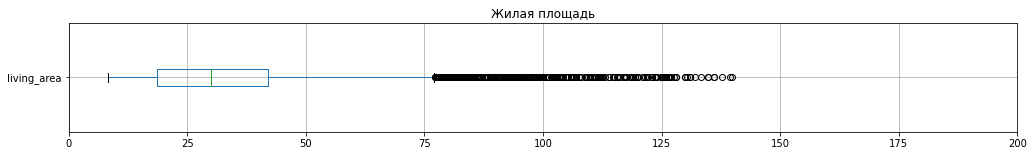

In [71]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['living_area']].boxplot(vert = False, ax =ax)
ax.set_title('Жилая площадь')
ax.set_xlim(0, 200);

--- основной массив данных о жилой площади находится в пределах 40 кв.м., но данные доходят и до 150-160м. Похоже на правду---

In [72]:
df['kitchen_area'].describe()

count    22829.000000
mean        10.080662
std          4.728337
min          5.000000
25%          7.400000
50%          8.900000
75%         11.240000
max         49.400000
Name: kitchen_area, dtype: float64

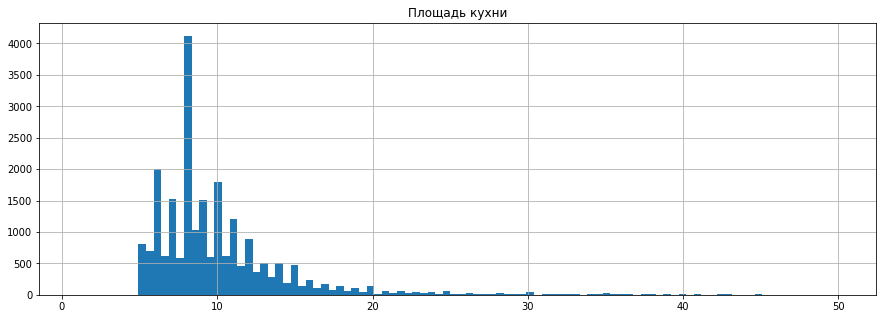

In [73]:
df['kitchen_area'].hist(bins=100, range=(1, 50), figsize= (15, 5));
plt.title('Площадь кухни');

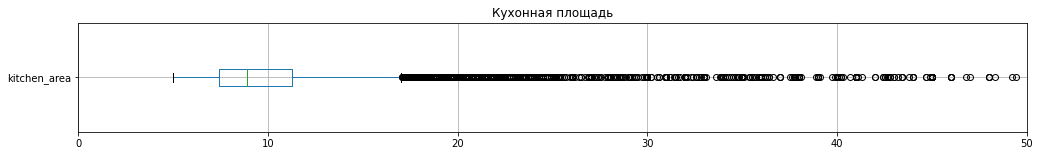

In [74]:
fig, ax = plt.subplots(figsize = (17,2))
ax = df[['kitchen_area']].boxplot(vert = False, ax =ax)
ax.set_title('Кухонная площадь')
ax.set_xlim(0, 50);

---есть максимальное значение кухни в 112кв.м., но его даже не видно на графике, основной массив - средние значения 9-10кв.м.---

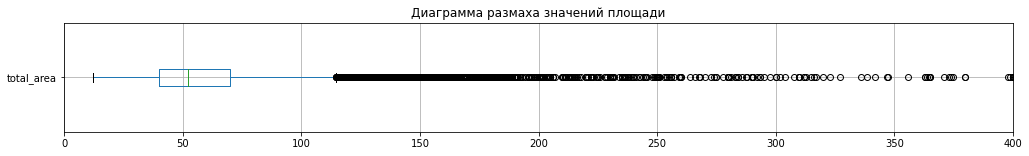

In [75]:
# check
# для примера горизонтальный вид диаграммы размаха

fig, ax = plt.subplots(figsize = (17,2))
ax = data[['total_area']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений площади')
ax.set_xlim(0, 400);

In [76]:
df['last_price'].describe()

count    2.282900e+04
mean     5.803151e+06
std      4.328065e+06
min      4.300000e+05
25%      3.400000e+06
50%      4.600000e+06
75%      6.650000e+06
max      3.999000e+07
Name: last_price, dtype: float64

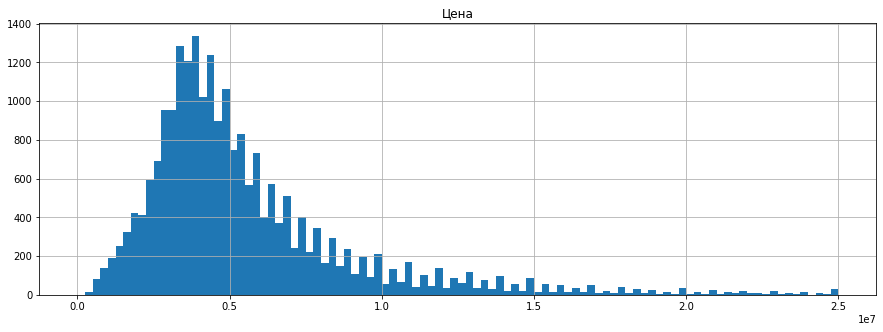

In [77]:
df['last_price'].hist(bins=100, range=(1, 25000000), figsize= (15, 5), grid=True);
plt.title('Цена');

---основная масса предложений до 5млн, далее идет равномерный спад до 25 млн.

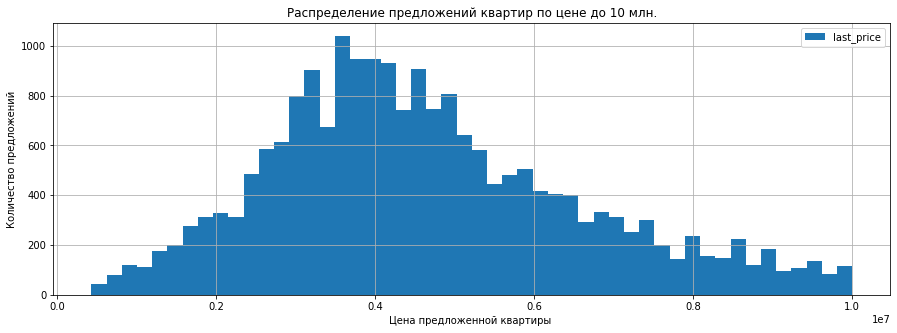

In [78]:
df.query('last_price < 10000000').plot(kind='hist', y='last_price', title='Распределение предложений квартир по цене до 10 млн.',grid=True, bins=50, figsize=(15,5))
plt.ylabel('Количество предложений')
plt.xlabel('Цена предложенной квартиры ')
plt.show()

---средняя цена довольно высокая и близка к максимальной, значит и количество дорогих квартир преобладающее.
с 2016 года наблюдается подъем, но в 2019 резкий спад. Число объявлений в этом году было в 3 раза меньше, возможно данные предоставлены не за полный год. Или количество площадок по продажам квартир резко увеличилось и у нас находятся не полные данные---

In [79]:
df['rooms'].describe()

count    22829.000000
mean         2.035175
std          0.994173
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: rooms, dtype: float64

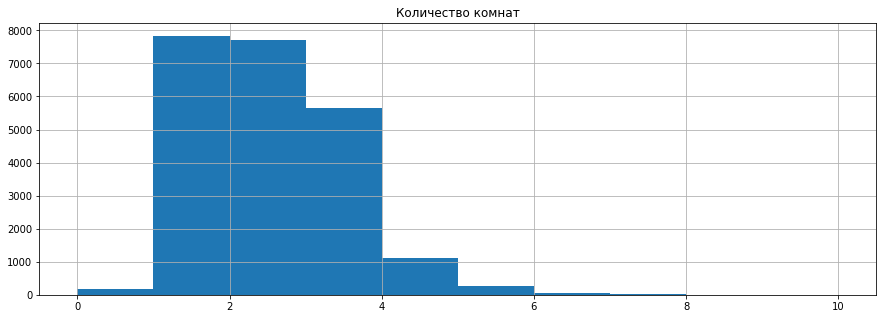

In [80]:
df['rooms'].hist(bins=10, range=(0, 10), figsize= (15, 5));
plt.title('Количество комнат');

--- в среднем 2 комнаты в квартире, максимум - 19. Возможно, что это полностью жилой этаж---

In [81]:
df['ceiling_height'].describe()

count    22829.000000
mean         2.737191
std          0.202864
min          2.000000
25%          2.600000
50%          2.770000
75%          2.770000
max          4.500000
Name: ceiling_height, dtype: float64

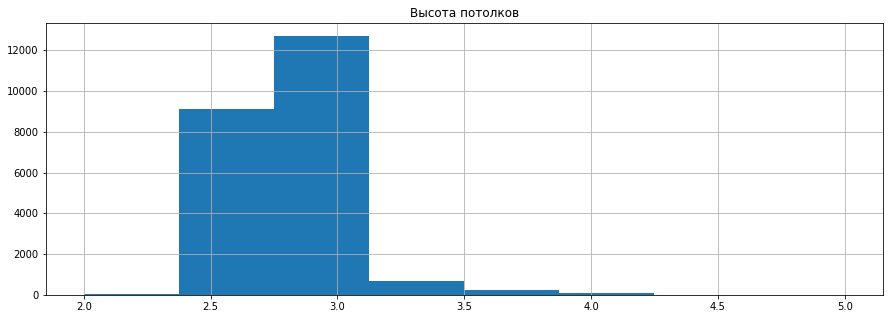

In [82]:
df['ceiling_height'].hist(bins=8,range=(2, 5), figsize= (15, 5));
plt.title('Высота потолков');

---высота потолков в среднем 2.7---

In [83]:
df['floor'].describe()

count    22829.000000
mean         5.899076
std          4.897027
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

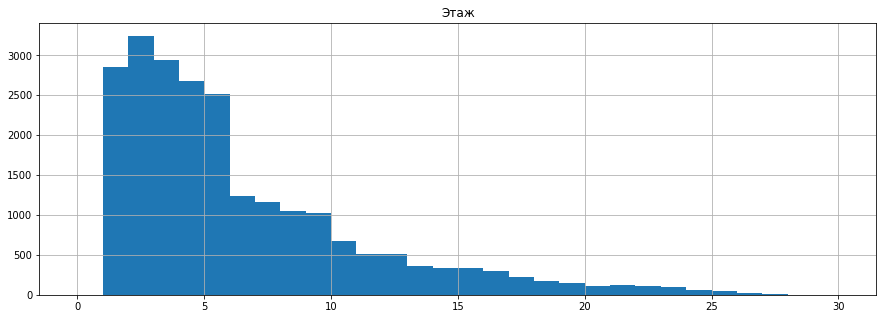

In [84]:
df['floor'].hist(bins=30, range=(0, 30), figsize= (15, 5));
plt.title('Этаж');

--- несмотря на огромную любовь застройщиков к высотным зданиям большинство квартир продается от 2 до 8 этажа---

In [85]:
df['floor_category'].describe()

count      22829
unique         3
top       другой
freq       16796
Name: floor_category, dtype: object

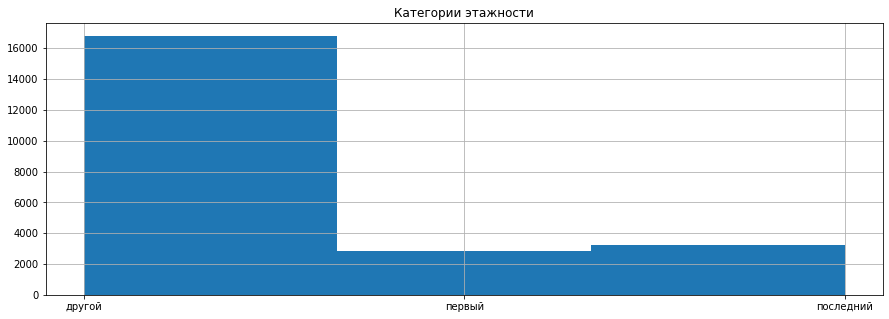

In [86]:
df['floor_category'].hist(bins=3, figsize= (15, 5));
plt.title('Категории этажности');

--- покупатели выбирают в большинстве ни первый, ни последний---

In [87]:
df['floors_total'].describe()

count    22829.000000
mean        10.667528
std          6.609501
min          0.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         35.000000
Name: floors_total, dtype: float64

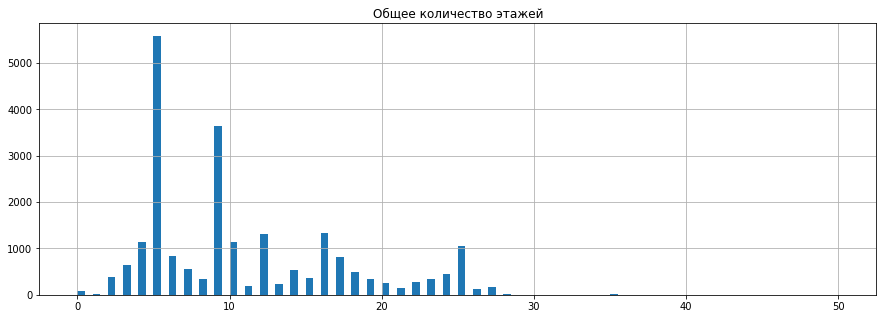

In [88]:
df['floors_total'].hist(bins=100, range=(0, 50), figsize= (15, 5));
plt.title('Общее количество этажей');

--- этажность зданий не выходит за рамки 30 этажей

In [89]:
df['cityCenters_nearest'].describe()

count    22829.000000
mean        10.565640
std          9.549111
min          0.000000
25%          2.000000
50%         11.000000
75%         15.000000
max         65.000000
Name: cityCenters_nearest, dtype: float64

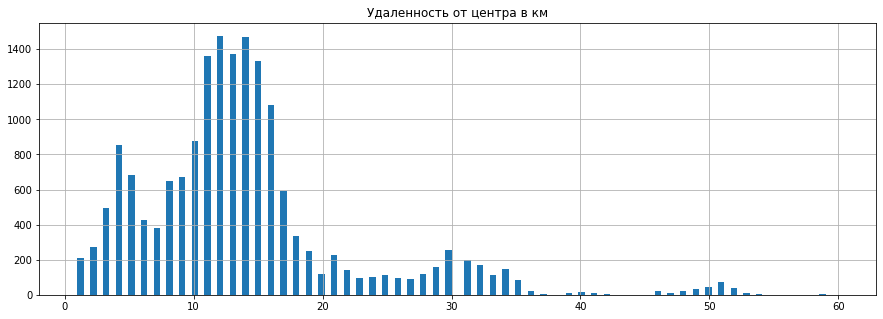

In [90]:
df['cityCenters_nearest'].hist(bins=120, range=(1, 60), figsize= (15, 5));
plt.title('Удаленность от центра в км');

--- основаная проблем здесь с нулевыми значениями. Когда не знаешь сколько до центра(да и что считать центром?) в порыве работы можно указать и 0. Менять на другое значение считаю некорректным<br>Основной массив продаж в радиусе 10-18км---

In [91]:
df['airports_nearest'].describe()

count    17395.000000
mean        28.859226
std         12.705199
min          6.450000
25%         18.503000
50%         26.858000
75%         37.407000
max         84.869000
Name: airports_nearest, dtype: float64

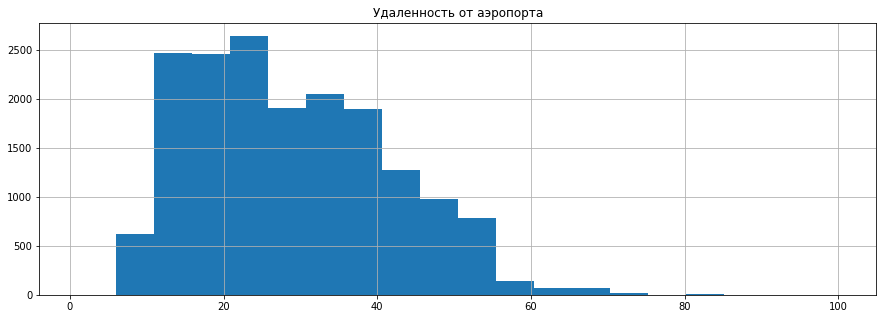

In [92]:
df['airports_nearest'].hist(bins=20, range=(1, 100), figsize= (15, 5));
plt.title('Удаленность от аэропорта');

--- возможно, здесь такая же история, как и с удаленностью от центра - слишком далеко(да и неизвестно).<br>В целом, хорошо, что рядом с аэропортом мало продаж - тише в квартире---

In [93]:
df['parks_nearest'].describe()

count    22829.000000
mean      2236.753800
std       1252.698498
min          1.000000
25%        612.000000
50%       3114.250000
75%       3114.250000
max       3190.000000
Name: parks_nearest, dtype: float64

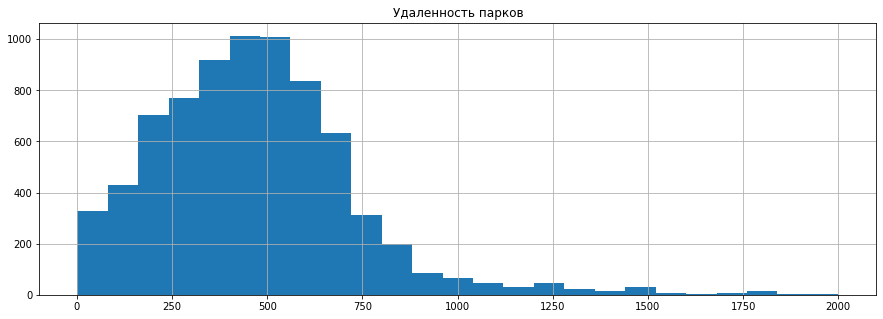

In [94]:
df['parks_nearest'].hist(bins=25, range=(1,2000), figsize= (15, 5));
plt.title('Удаленность парков');

--- большинство квартир продается в Питербурге, городе-парке---

In [95]:
df['weekday_exposition'].describe()

count    22829.000000
mean         2.561172
std          1.787412
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: weekday_exposition, dtype: float64

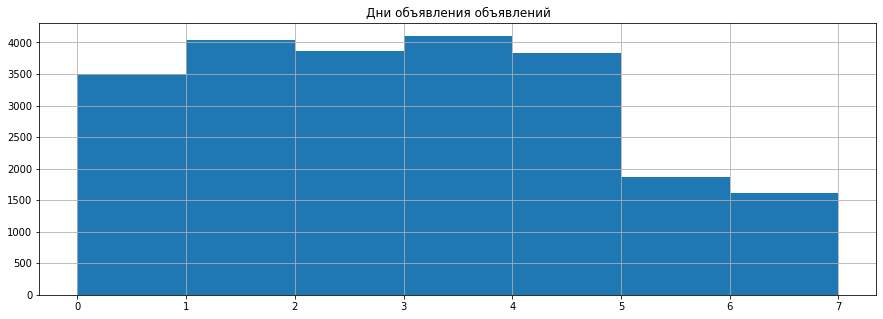

In [96]:
df['weekday_exposition'].hist(bins=7, range=(0,7), figsize= (15, 5));
plt.title('Дни объявления объявлений');

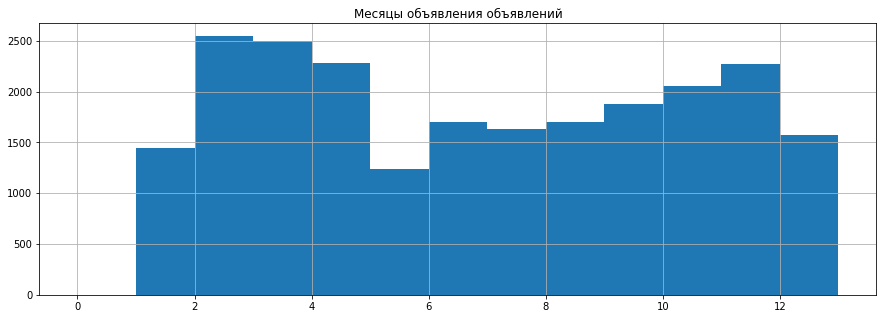

In [97]:
df['month_exposition'].hist(bins=13, range=(0,13), figsize= (15, 5));
plt.title('Месяцы объявления объявлений');

--- по выходным люди отдыхают, а продают квартиры в будние дни---

--- и в январе и декабре(особенно в Питере)людям не до продаж квартир. Чаще продают весной и осенью

# 4.1 Изучим, как быстро продавались квартиры 
Построим гистограмму.

In [98]:
df['days_exposition'] = df['days_exposition'].replace({'0': np.NaN, 0: np.NaN})

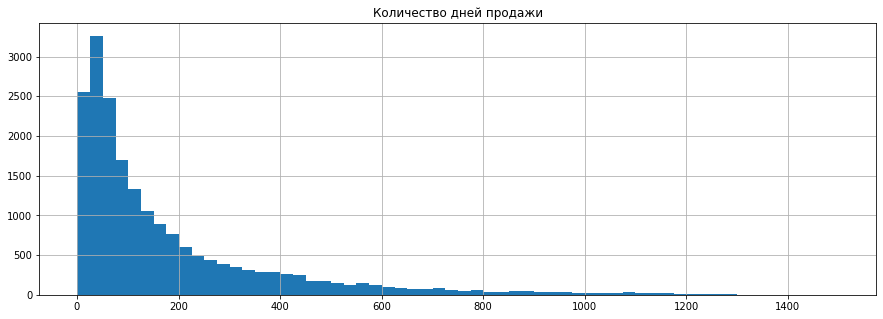

In [99]:
df.hist('days_exposition', bins=60, range = (1, 1500), figsize= (15, 5));
plt.title('Количество дней продажи');

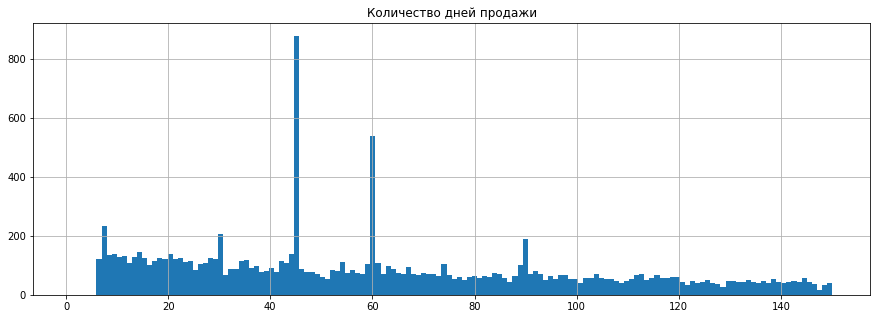

In [100]:
df.hist('days_exposition', bins=150, range = (1, 150), figsize= (15, 5));
plt.title('Количество дней продажи');

---пики дней продаж связаны с выставлением объявлений в сервисе, на 45,60 и 90 днях кончался период активности объявления и владельцы или отмечали сделку, как состоявшуюся или выставляли новое объявление

In [101]:
hist_data = df.query('days_exposition < 250')
hist_data['days_exposition'].agg(['mean','median'])

mean      85.667108
median    66.000000
Name: days_exposition, dtype: float64

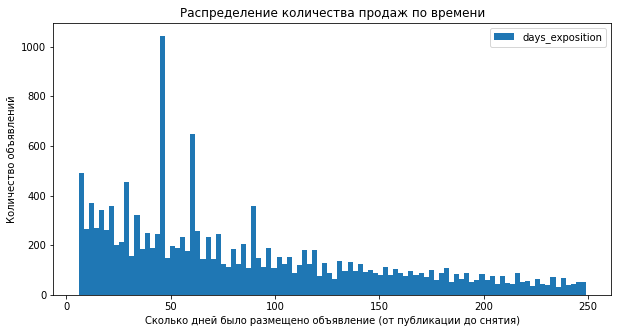

In [102]:
hist_data.plot(kind='hist',y='days_exposition',title='Распределение количества продаж по времени', bins=100, figsize=(10,5))
plt.xlabel('Сколько дней было размещено объявление (от публикации до снятия)')
plt.ylabel('Количество объявлений')
plt.show()

In [103]:
df['days_exposition'].describe()

count    19724.000000
mean       180.613212
std        210.666677
min          6.000000
25%         45.000000
50%         98.000000
75%        232.000000
max       1299.000000
Name: days_exposition, dtype: float64

--- среднее по дням продажи составляет 180, а медиана - 100
Большинство продаж укладываются в срок до 200 дней - полгода, медианное значение - 100 - 3 месяца.
Аномально долгие продажи также присутствуют. Возможно они связаны с недостаточностью информации, удаленностью от центра и завышенной ценой.---

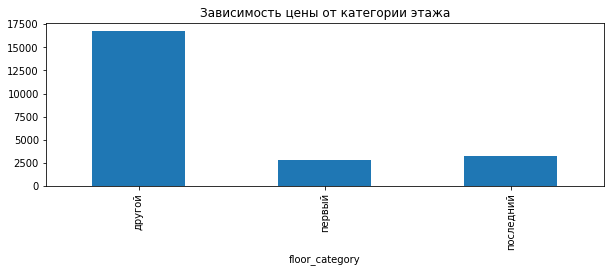

In [104]:
df.groupby('floor_category')['last_price'].count().plot(kind = 'bar', figsize= (10, 3));
plt.title('Зависимость цены от категории этажа');

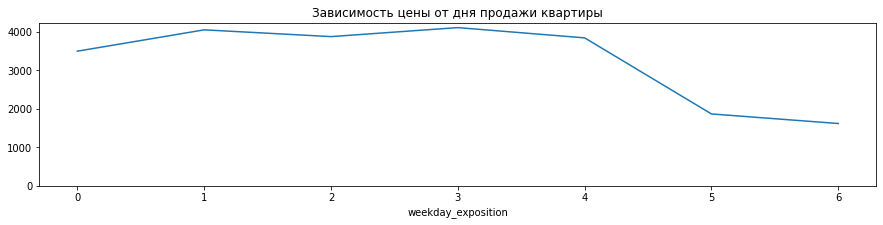

In [105]:
df.groupby('weekday_exposition')['last_price'].count().plot(ylim=0, figsize= (15, 3));
plt.title('Зависимость цены от дня продажи квартиры');

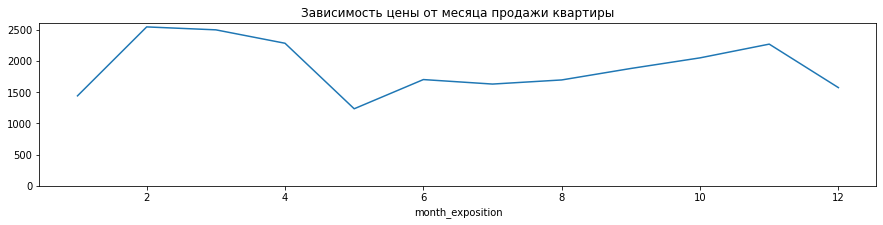

In [106]:
df.groupby('month_exposition')['last_price'].count().plot(ylim=0, figsize= (15, 3));
plt.title('Зависимость цены от месяца продажи квартиры');

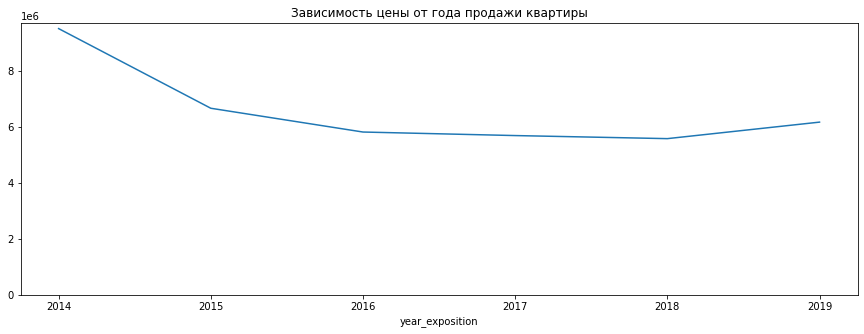

In [107]:
df.groupby('year_exposition')['last_price'].mean().plot(figsize= (15, 5), ylim=0);
plt.title('Зависимость цены от года продажи квартиры');

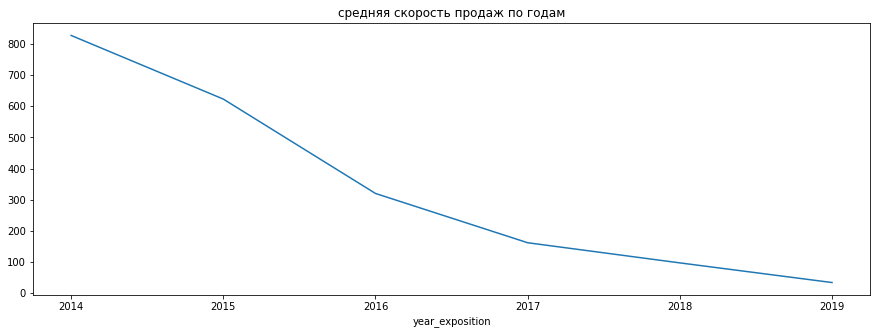

In [108]:
df.groupby('year_exposition')['days_exposition'].mean().plot(figsize= (15, 5));
plt.title('средняя скорость продаж по годам');

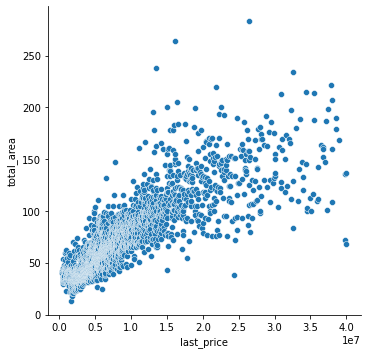

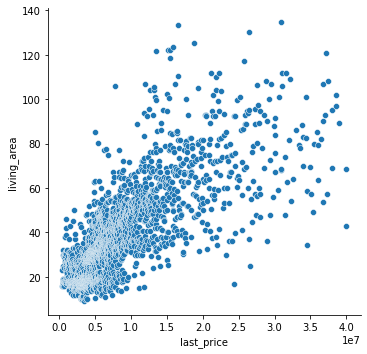

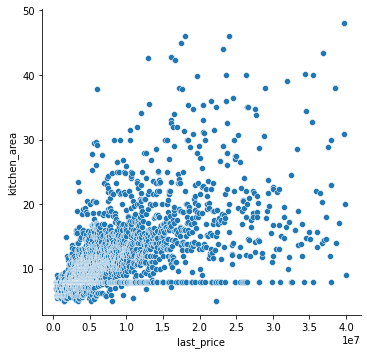

In [109]:
price_pivot_area1 = df.pivot_table(index='last_price', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area1 = price_pivot_area1.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area1, x='last_price', y=row, kind='scatter')

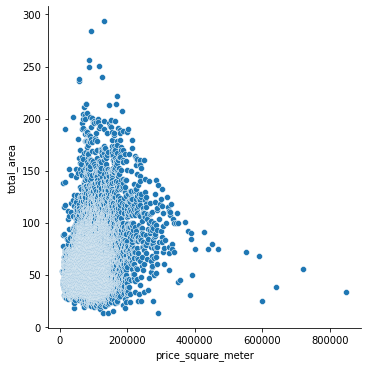

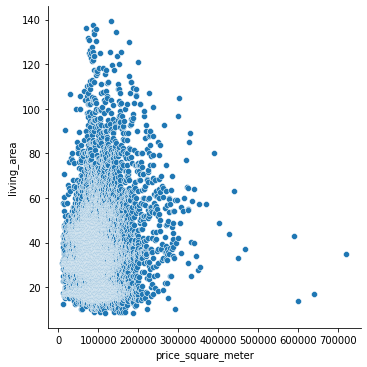

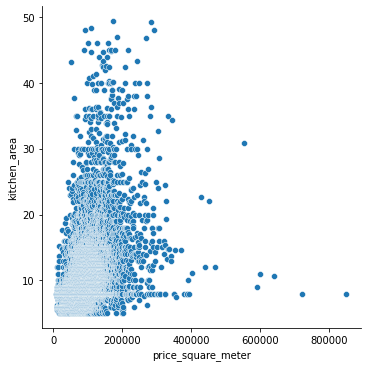

In [110]:
price_pivot_area2 = df.pivot_table(index='price_square_meter', values=([
    'total_area', 'living_area', 'kitchen_area']), aggfunc='median')
price_pivot_area2 = price_pivot_area2.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['total_area', 'living_area', 'kitchen_area']:
    sns.relplot(data=price_pivot_area2, x='price_square_meter', y=row, kind='scatter')

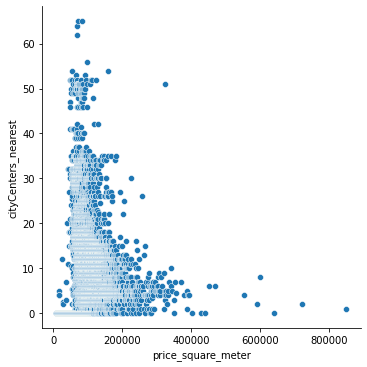

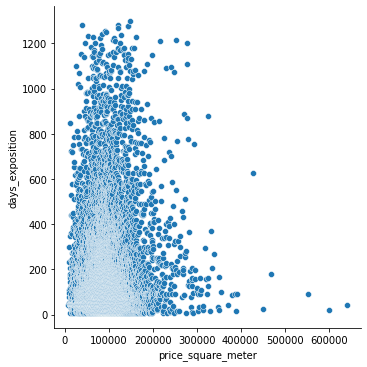

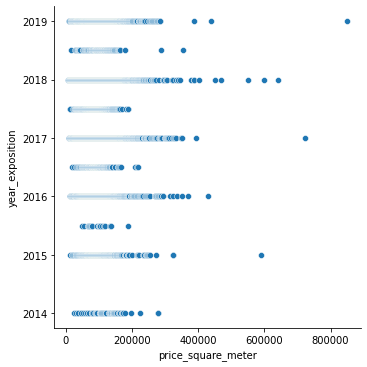

In [111]:
price_pivot_area2 = df.pivot_table(index='price_square_meter', values=([
    'cityCenters_nearest', 'days_exposition', 'year_exposition']), aggfunc='median')
price_pivot_area2 = price_pivot_area2.reset_index()
# Посмотрим на диаграммы рассеяния для столбцов 'total_area', 'living_area', 'kitchen_area'.
for row in ['cityCenters_nearest', 'days_exposition', 'year_exposition']:
    sns.relplot(data=price_pivot_area2, x='price_square_meter', y=row, kind='scatter')

# 4.2.На продажу влияют такие показатели, как общая площадь и цена одного квадратного метра

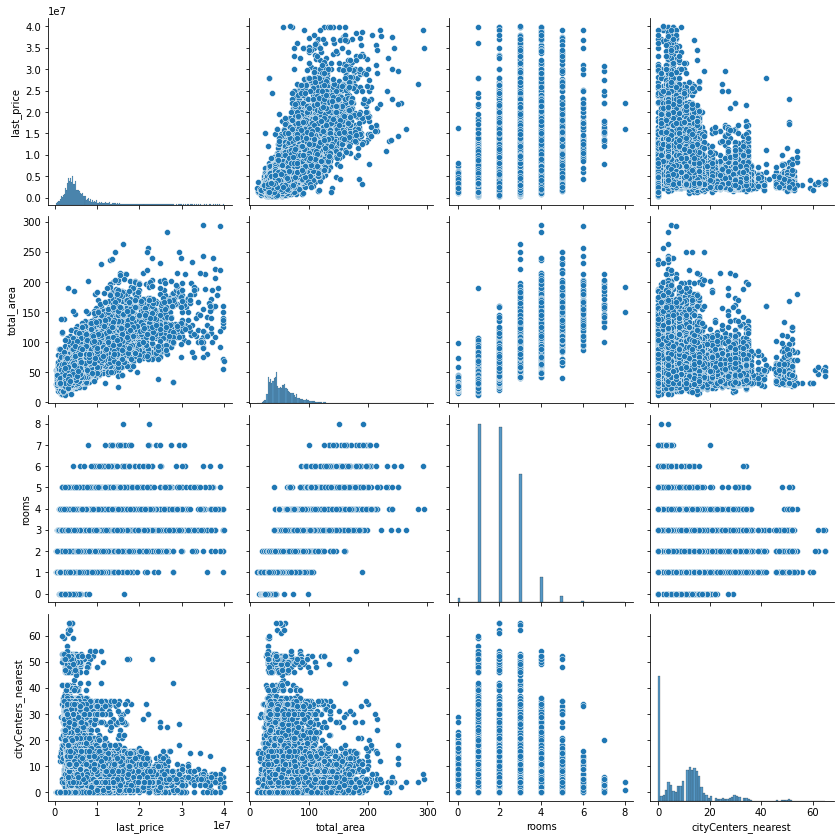

In [113]:
sns.pairplot(df[['last_price', 'total_area', 'rooms', 'cityCenters_nearest']])
plt.gcf().set_size_inches(12,12);

--- на цену влияет количество общей площади, жилой площади и цена квадратного метра---

### 4.3. Посчитаем среднюю цену одного кв. метра в 10 населенных пунктах.

In [114]:
df['cityCenters_nearest'].unique()#проверим на аномальные значения

array([16, 18, 13,  8,  0, 19, 11, 15, 51, 33, 30, 14, 10, 12,  9,  2, 32,
        3,  6,  4, 49, 23, 27,  5, 26, 21, 50, 17, 52, 48, 34,  7, 36, 35,
       24, 29,  1, 31, 25, 53, 54, 22, 20, 65, 46, 39, 28, 56, 41, 42, 62,
       59, 40, 64, 38, 43, 47, 37, 45, 61, 60])

In [115]:

df_groupby = df.groupby(['locality_name','year_exposition']).agg(['count','mean'])#.sort_values(ascending=False)
locality_pivot_table = df.pivot_table(index = 'locality_name', values = 'price_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False)

locality_pivot_table.astype(int).head(10)

,count,mean
locality_name,,
Санкт_Петербург,15020,111598
посёлок Мурино,540,85619
посёлок Шушары,433,78738
Всеволожск,390,68771
Пушкин,351,102473
Колпино,327,75314
посёлок Парголово,318,90057
Гатчина,299,68739
деревня Кудрово,292,92342


Text(0.5, 1.0, 'Цена за кв.м.\n')

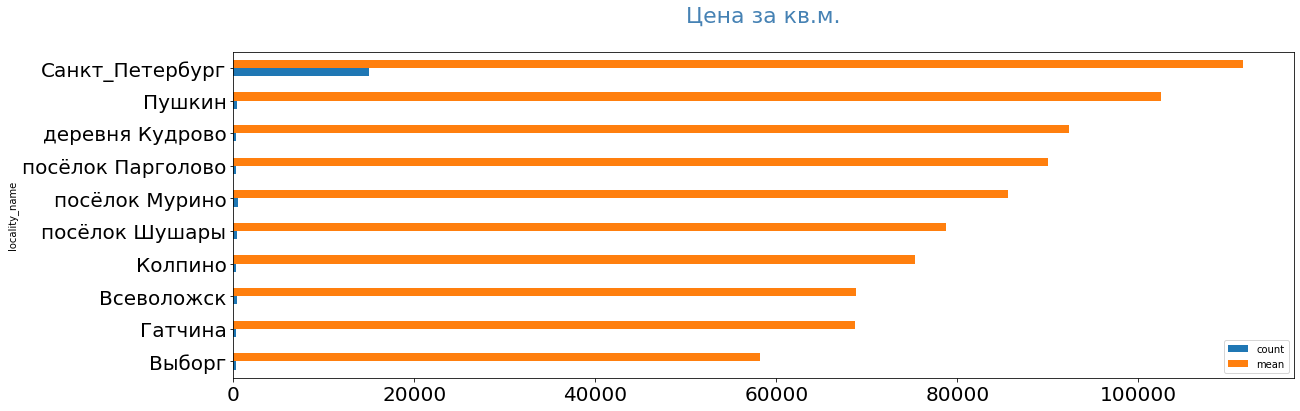

In [116]:
locality_pivot_table=locality_pivot_table.head(10)
(
            locality_pivot_table.iloc[:10]
            .sort_values(by = 'mean', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = True, fontsize = 20)
            .set_title('Цена за кв.м.' + "\n", fontsize = 22, color = 'SteelBlue')
        )

In [117]:
locality_pivot_table.astype(int).sort_values('mean', ascending = False).head(10)

,count,mean
locality_name,,
Санкт_Петербург,15020,111598
Пушкин,351,102473
деревня Кудрово,292,92342
посёлок Парголово,318,90057
посёлок Мурино,540,85619
посёлок Шушары,433,78738
Колпино,327,75314
Всеволожск,390,68771
Гатчина,299,68739


--- самый активный по продажам населенный пункт - Санкт-Петербург и самый дорогой по цене квадратного метра - 108т.р.---

In [118]:
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]

,count,mean
locality_name,,
Санкт_Петербург,15020,111598.34494


In [119]:
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Выборг,233,58138.201717


--- в деревне Старополье есть 3 предложения с самымы дешевым кв.метром - 11т.р.---

# 4.4. Выделим квартиры Питербурга и найдем средную цену километра от центра города

---средняя цена за кв.м. по Питеру и по удаленности от центра

In [120]:

pd.options.mode.chained_assignment = None
data_spb = df[df.locality_name.isin(['Санкт_Петербург'])]  
data_spb['cut_center'] = pd.cut(data_spb['cityCenters_nearest'], 29)
data_spb.pivot_table(index = 'cut_center', values = 'price_square_meter', aggfunc=['count', 'mean']).sort_values(by='cut_center')#.head(10)

,count,mean
,price_square_meter,price_square_meter
cut_center,,
"(-0.029, 1.0]",327,141699.920489
"(1.0, 2.0]",270,126595.666667
"(2.0, 3.0]",490,120739.244898
"(3.0, 4.0]",843,134047.619217
"(4.0, 5.0]",684,134630.036550
"(5.0, 6.0]",426,137969.002347
"(6.0, 7.0]",382,131016.897906
"(7.0, 8.0]",644,120548.644410


--- в предложенных колонках по фильтрации (санкт-петербург) радиус от центра города нам предлагается расстояние в 30км

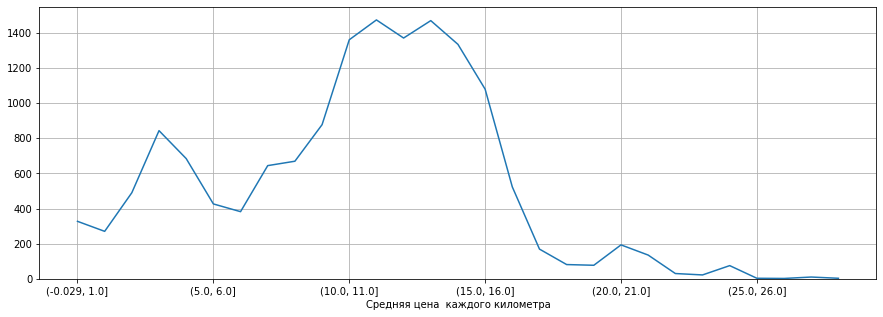

In [121]:
# data_spb = data_spb.loc[data_spb['cityCenters_nearest'] < 20]
cut_km_mean = data_spb.groupby('cut_center')['last_price'].count();
cut_km_mean.plot(figsize=(15, 5), ylim=0, grid=True);
plt.xlabel('Средняя цена  каждого километра');

---цена вырастает в дипазоне в 10-15 км, возможно, что это новострой, построенный в пригороде, вне исторической застройки

In [122]:
data_spb = data_spb.loc[data_spb['cityCenters_nearest'] < 30]
mean_cost_per_km = data_spb['last_price'].sum()/data_spb['cityCenters_nearest'].sum()#средняя цена за километр
print('Средняя цена для каждого километра составляет {:.0f} ₽'.format(mean_cost_per_km))

Средняя цена для каждого километра составляет 625000 ₽


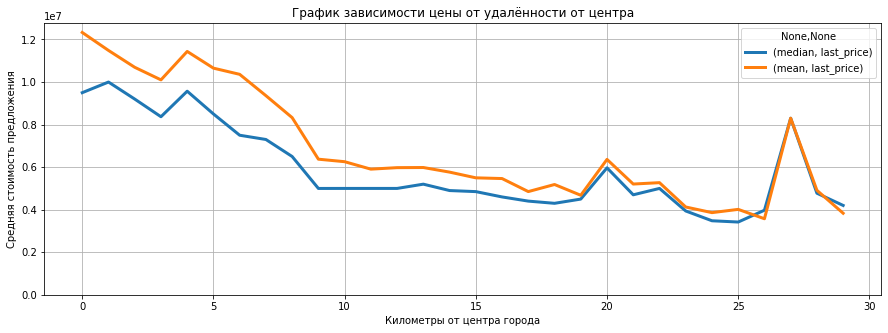

In [123]:

(data_spb
 .pivot_table(index='cityCenters_nearest', values='last_price', aggfunc=['median', 'mean'])
 .plot(figsize=(15,5),ylim=0, grid=True, linewidth=3, title='График зависимости цены от удалённости от центра')
)
plt.xlabel('Километры от центра города')
plt.ylabel('Средняя стоимость предложения')
plt.show()

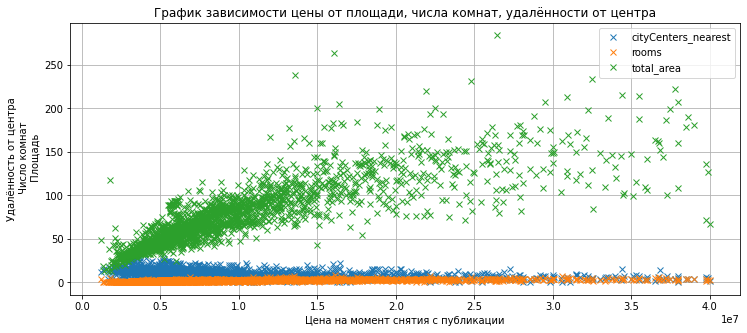

In [124]:
(data_spb    
     .pivot_table(index='last_price', values=['rooms','total_area','cityCenters_nearest'])
     .plot(style='x',grid=True, figsize=(12, 5), title='График зависимости цены от площади, числа комнат, удалённости от центра')
)
plt.xlabel('Цена на момент снятия с публикации')
plt.ylabel('Удалённость от центра\n Число комнат\n Площадь')
plt.show()

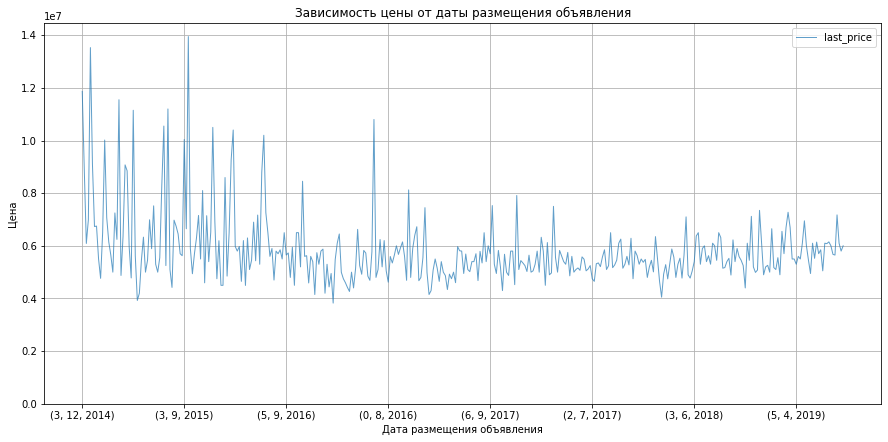

In [125]:
(data_spb
 .pivot_table(index=['weekday_exposition','month_exposition','year_exposition'], values='last_price', aggfunc='median')
    .sort_values(by='year_exposition')
    .plot(grid=True,linewidth=1, alpha=0.7, label='2022',figsize=(15,7),ylim=0, title='Зависимость цены от даты размещения объявления')
)

plt.xlabel('Дата размещения объявления')
plt.ylabel('Цена')
plt.show()

---здесь возможно показано условное беспокойство рынка в 2014-2016 году, когда был кризис и рынок пытался регулировать цены

 <div class="alert alert-info"  style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
    
<h2># 5.Общий вывод: <a class="tocSkip"> </h2>
1. Очень много предложений по продажам в самом городе.<br> 
2. *Популярное предложение это квартира* <br>-от 15 км от центра города,<br> -в отдаленности от аэропорта, <br>-1-2 комнатной планировки <br>-рядом с парком или зеленой зоной, <br>-со средней ценой за кв.метр - 110т.р. <br>-и площадью около 60кв.м.<br>-не высотной застройки<br>-возможно, что это высотная застройка по периметру города
---Подобная квартира в среднем продается до 3х месяцев.---<br> 
3. Не популярное предложение - <br>квартира огромной площади,<br>на первом или последнем этаже,<br> с ценой завышенного квадратного метра -  выше 110т.р. <br>
---Подобное предложение может не заинтересовать покупаетелей до 
</div>
    
</div>